### Drugi deo - klasifikacija planeta i satelita uz veštačku augmentaciju slika

Kao pokušaj poboljšanja efikasnosti modela, augmentacija slika može da pomogne. Tako će se baza slika proširiti i model će imati veći skup na raspolaganju za učenje, validaciju i treniranje, i bolju sposobnost prilagođavaja na neviđenim podacima.


Biće primenjen isti model kao i u prvom delu, kako na planetama tako i na satelitima, radi upoređivanja konačnih dobijenih rezultata.

## Planete

Za učitavanje slika, ovaj put će biti prikazano korišćenje klase ImageDataGenerator.

Klasa *ImageDataGenerator* u Kerasu omogućava različite tehnike augmentacije podataka, poput rotacije, skaliranja, horizontalnog i vertikalnog zrcaljenja, promene svetline i kontrasta, što pomaže u obogaćivanju skupa podataka i poboljšanju generalizacije modela.  

ImageDataGenerator se obično koristi zajedno sa metodama *flow_from_directory* ili *flow* za generisanje podataka u obliku koji je pogodan za treniranje modela.

##### Učitavanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import random
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

2024-03-13 11:29:01.962197: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:29:01.992721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 11:29:01.992775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 11:29:01.993478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 11:29:01.997800: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:29:01.998224: I tensorflow/core/platform/cpu_feature_guard.cc:1

I ovog puta, baza slika će biti kreirana pomoću putanja do njih.

In [25]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Koreni direktorijum u kom se nalaze slike
data_dir = 'planete'

# Definisanje imena klasa u alfabetskom redu
planete = ['Jupiter', 'Mars', 'Merkur', 'Neptun', 'Saturn', 'Uran', 'Venera', 'Zemlja']

# Definisanje praznih listi u koje će biti smeštene putanje i oznake klasa
putanje = []
oznake = []

# Popunjavnje listi
for i, planeta in enumerate(planete):
    planeta_dir = os.path.join(data_dir, planeta)
    fajlovi = os.listdir(planeta_dir)
    putanje += [os.path.join(planeta_dir, fajl) for fajl in fajlovi]
    oznake += [i] * len(fajlovi)


### Definisanje funkcije za podelu na test, trening i validacioni skup

Ova funkcija će smanjiti količinu ponovljenog koda, pošto će se ista klasa koristiti za podelu i skupa planeta, i skupa satelita.

Funkcija će kao parametre primati niz putanja do slika i oznake klase kojima te slike pripadaju, a vraćaće skup za trening, test i validaciju.

In [3]:
# Definisanje veličine gomile i veličine slike
batch_size = 32
target_size = (256, 256) 

In [4]:
def podeli_bazu(putanje, oznake):
    
    # Stratifikovana podela skupa na test i trening, 70% za trening, 30% za test
    # Random_state parametar je tu da bi podela pri svakom pokretanju bila istovetna
    X_train, X_test, y_train, y_test = train_test_split(putanje, oznake, test_size=0.3, stratify=oznake, random_state=42)
    # Podela ostatak dataset-a na validacioni (10%) i test (20%) skup
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, stratify=y_test, random_state=42)
    
    # Konvertovanje oznaka, koje su trenutno tipa int, u stringove, da bi model mogao da ih primi
    y_train = [str(oznaka) for oznaka in y_train]
    y_test = [str(oznaka) for oznaka in y_test]
    y_val = [str(oznaka) for oznaka in y_val]
    
    dataframe = pd.DataFrame({'filename':X_train, 'class':y_train})
    
    # Korišćenje klase ImageDataGeneratori definisanje augmentacija koje će biti primenjene na slike
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalizacija piksela na [0, 1]
        rotation_range=20,  # Nasumična rotacija slika do 20 stepeni
        width_shift_range=0.2,  # Nasumično pomeranje slika horizontalno do 20% širine
        height_shift_range=0.2,  # Nasumično pomeranje slika vertikalno do 20% visine
        shear_range=0.2,  # Ugao pomeranja u radijanima
        zoom_range=0.2,  # Nasumično uvećanje slika do 20% 
        horizontal_flip=True,  # Nasumično horizontalno obrtanje slika
        fill_mode='nearest'  # U slučaju nedostajućih piksela, popuniti vrednosti koristeći najbližu vrednost
    )
    
    
    # Generatori za trening, test i validacioni skup
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse', 
        interpolation="lanczos",
        shuffle=True
    )
    
    test_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        interpolation="lanczos",
        shuffle=False
    )
    
    val_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        interpolation="lanczos",
        shuffle=False
    )

    return train_generator, test_generator, val_generator

Parametar *interpolation="lanczos"* koristi se prilikom promene veličine slika prilikom učitavanja pomoću ImageDataGenerator objekta. Interpolacija se koristi za izračunavanje novih vrednosti piksela kada se slika promeni u veličini. U ovom slučaju, *"lanczos"* je metoda interpolacije koja se koristi za glatko skaliranje slika. Lanczos interpolacija je složenija metoda koja pruža bolje rezultate u očuvanju detalja i smanjenju pojave "stepenastih" ivica koje se mogu pojaviti kod drugih metoda interpolacije. 

In [26]:
train_generator_planete, test_generator_planete, val_generator_planete = podeli_bazu(putanje, oznake)

Found 834 validated image filenames belonging to 8 classes.
Found 239 validated image filenames belonging to 8 classes.
Found 239 validated image filenames belonging to 8 classes.


##### Učitavanje prethodno napravljenog modela

In [6]:
from tensorflow.keras.models import load_model

model = load_model('modelP')

2024-03-13 11:29:06.732709: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


### Kompilacija, treniranje i evaluacija modela

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator_planete, validation_data=val_generator_planete, batch_size=batch_size, epochs=10, verbose=1)

Epoch 1/10
27/27 [==============================] - 43s 2s/step - loss: 0.9468 - accuracy: 0.7722 - val_loss: 0.3956 - val_accuracy: 0.8661
Epoch 2/10
27/27 [==============================] - 40s 1s/step - loss: 0.0877 - accuracy: 0.9652 - val_loss: 0.0427 - val_accuracy: 0.9791
Epoch 3/10
27/27 [==============================] - 41s 1s/step - loss: 0.0545 - accuracy: 0.9772 - val_loss: 0.0462 - val_accuracy: 0.9791
Epoch 4/10
27/27 [==============================] - 43s 2s/step - loss: 0.0335 - accuracy: 0.9892 - val_loss: 0.0597 - val_accuracy: 0.9874
Epoch 5/10
27/27 [==============================] - 42s 2s/step - loss: 0.1002 - accuracy: 0.9820 - val_loss: 0.0777 - val_accuracy: 0.9623
Epoch 6/10
27/27 [==============================] - 41s 2s/step - loss: 0.1021 - accuracy: 0.9736 - val_loss: 0.0579 - val_accuracy: 0.9833
Epoch 7/10
27/27 [==============================] - 43s 2s/step - loss: 0.2286 - accuracy: 0.9329 - val_loss: 0.1450 - val_accuracy: 0.9247
Epoch 8/10
27/27 [==

In [28]:
 # Rezultati na test skupu
rezultati = model.evaluate(test_generator_planete, verbose=0)
print("    Gubitak:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(rezultati[0]))
print(" Preciznost:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(rezultati[1] * 100))


    Gubitak:  0.03529  
 Preciznost:  98.74%  


*Loss* (gubitak) je numerička vrednost koja predstavlja grešku između stvarnih i predviđenih vrednosti. Cilj je minimizovati ga, što znači da model što preciznije predviđa klase slika. Visok gubitak može značiti da se model preprilagodio i da nema dobru sposobnost generalizacije podataka.

### Grafički prikaz treniranja modela 

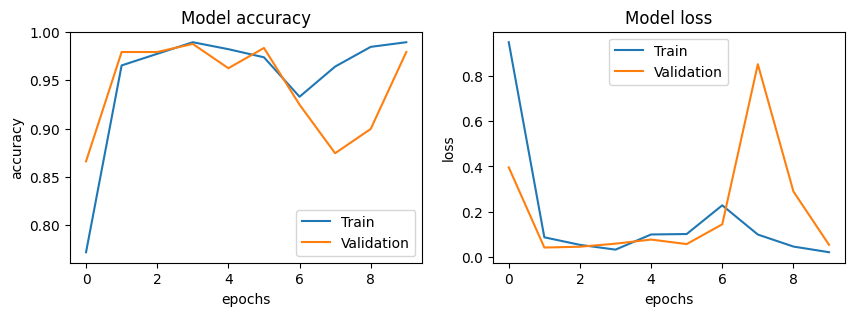

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Validation'])
plt.show()

### Upotreba modela u klasifikaciji planeta

Za primer upotrebe, model će uzeti nekoliko nasumično izabranih slika iz test skupa (da bi bilo sigurno da ih nije već video ranije) i predvideti njihove klase. 

1/1 [==============================] - 0s 21ms/step


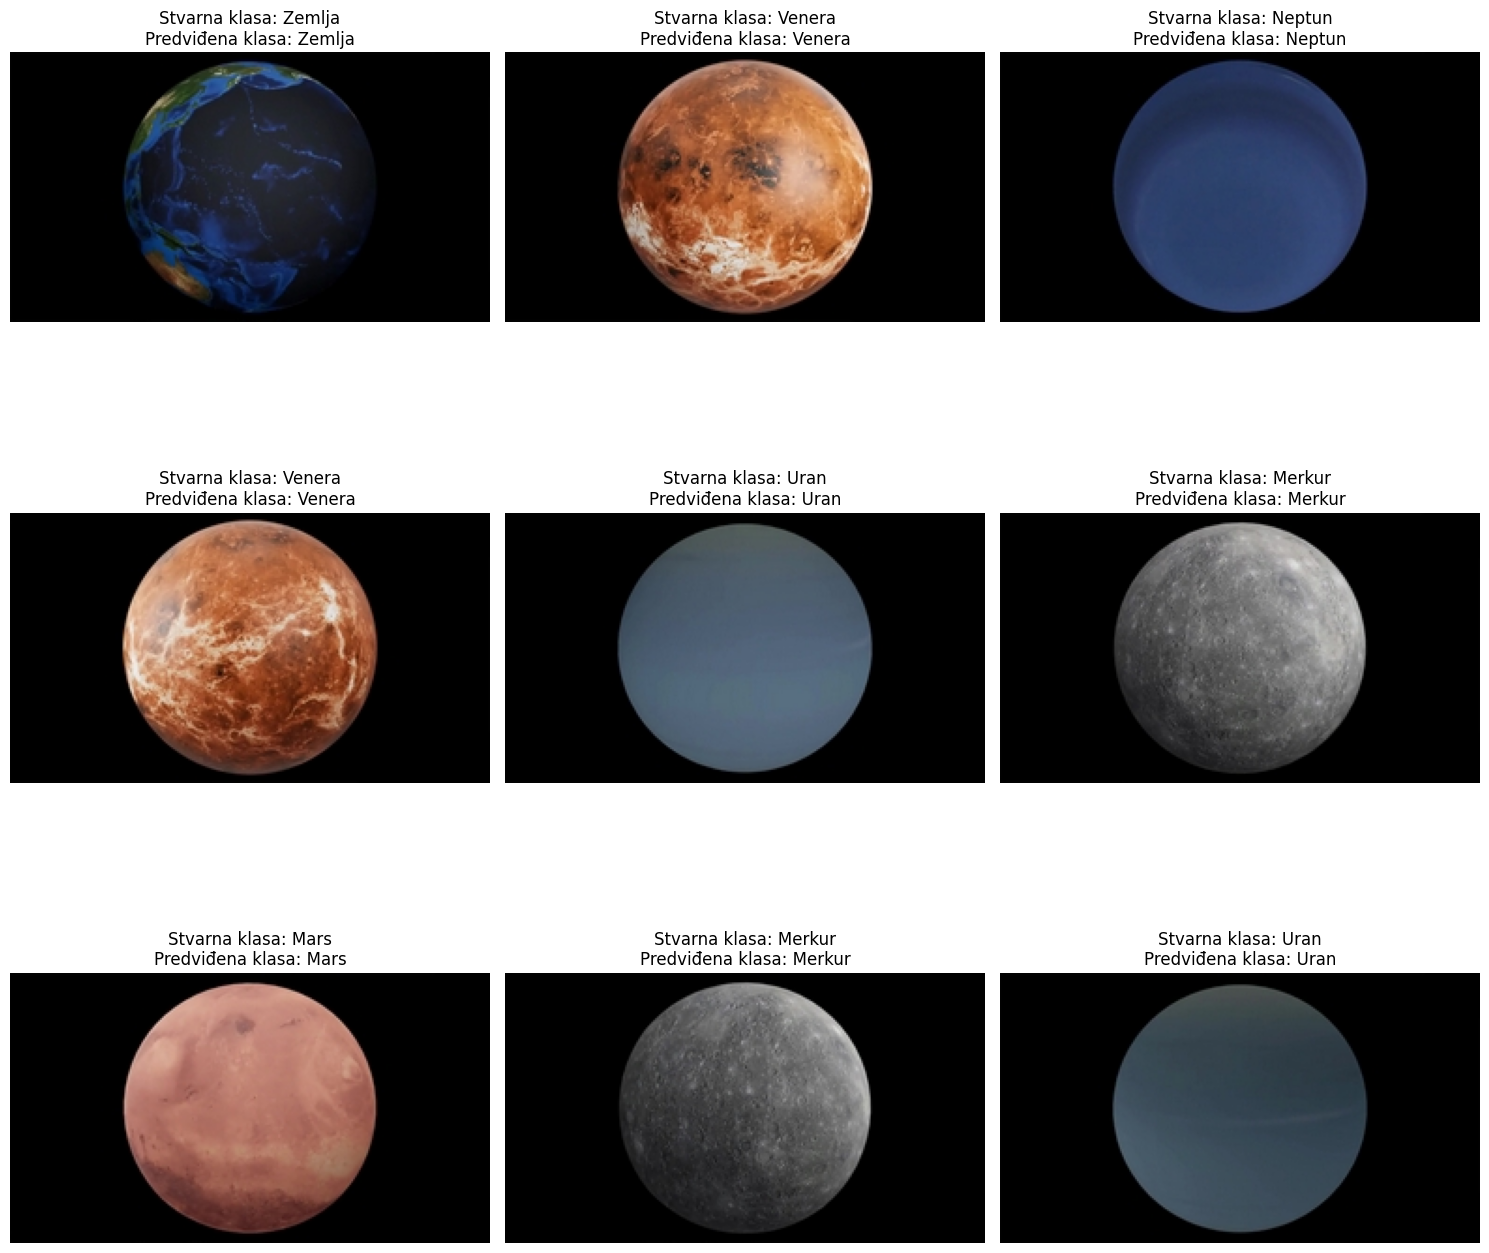

In [10]:
from tensorflow.keras.preprocessing import image 
# Dobijanje random 9 putanja iz test generatora
putanje = np.random.choice(test_generator_planete.filepaths, 9, replace=False)

# Prikazivanje slika sa random putanja
plt.figure(figsize=(15, 15))
for i, putanja in enumerate(putanje):
    
    # Učitavanje slike
    slika = plt.imread(putanja)

    # Učitavanje slike sa putanje
    img = image.load_img(putanja, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Normalizacija slike 
    x = x / 255.0  # Normalizacija piksela na [0, 1] opseg
    
    # Predviđanje klase
    predikcija = model.predict(x)
    
    # Pretvaranje predikcije u čitljiv oblik
    klasa_predikcije = planete[np.argmax(predikcija)]
    
    # Dobijanje oznake klase iz putanje
    klasa = putanja.split('/')[-2]  # Pretpostavka da je klasa pretposlednji deo putanje
    
    # Prikaz slike
    plt.subplot(3, 3, i + 1)
    plt.imshow(slika)
    plt.title(f"Stvarna klasa: {klasa}\nPredviđena klasa: {klasa_predikcije}")
    plt.axis('off')

plt.tight_layout()
plt.show()



# ---------------------------------------------------------------------------------------------------------------

## Sateliti

Model se odlično pokazao na predviđanju planeta, kao i u prethodnom slučaju.  
Međutim, malopre je veći izazov bio predviđanje satelita, čega je poboljšanje cilj ovog načina optimizacije modela.  

In [22]:
def planeta_kojoj_pripada(satelit):
    if satelit == 'Mesec':
        return 'Zemlja'
    elif satelit == 'Fobos' or satelit == 'Deimos':
        return 'Mars'
    elif satelit == 'Kalisto' or satelit == 'Evropa' or satelit == 'Ganimed' or satelit == 'Io':
        return 'Jupiter'
    else:
        return 'Saturn'

### Ucitavanje baze

In [11]:
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

data_dir = 'sateliti'

maticne_planete = ['Jupiter','Mars','Saturn','Zemlja']

# Lista satelita
sateliti = ['Evropa', 'Ganimed', 'Io', 'Kalisto', 'Deimos', 'Fobos', 'Enkelad','Mimant','Reja','Titan', 'Mesec']

slike_putanje = [] # Bice korisceno za prikaz slika iz test skupa
oznake = []
j = 0;

# Popunjavanje slika iz svakog poddirektorijuma
# Svaka kategorija ce biti numerička, označena brojevima 0-10
for i, planeta in enumerate(maticne_planete):
    planeta_dir = os.path.join(data_dir, planeta)
    lista_satelita = os.listdir(planeta_dir)
    for satelit in lista_satelita:
        satelit_dir = os.path.join(planeta_dir,satelit)
        slike = os.listdir(satelit_dir)
        for slika in slike:
            slika_putanja = os.path.join(satelit_dir, slika)
            img = image.load_img(slika_putanja, target_size=(256,256))
            slike_putanje.append(slika_putanja)
            oznake.append(j)
        j = j+1

In [12]:
train_generator_sateliti, test_generator_sateliti, val_generator_sateliti = podeli_bazu(slike_putanje, oznake)

Found 343 validated image filenames belonging to 11 classes.
Found 99 validated image filenames belonging to 11 classes.
Found 99 validated image filenames belonging to 11 classes.


/home/pepi/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


### Treniranje i evaluacija

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator_sateliti, validation_data=val_generator_sateliti, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
11/11 [==============================] - 22s 2s/step - loss: 1.3412 - accuracy: 0.5714 - val_loss: 1.7891 - val_accuracy: 0.3939
Epoch 2/20
11/11 [==============================] - 21s 2s/step - loss: 1.1514 - accuracy: 0.6327 - val_loss: 1.7856 - val_accuracy: 0.3636
Epoch 3/20
11/11 [==============================] - 21s 2s/step - loss: 1.1019 - accuracy: 0.6443 - val_loss: 1.7085 - val_accuracy: 0.4343
Epoch 4/20
11/11 [==============================] - 21s 2s/step - loss: 1.0427 - accuracy: 0.6531 - val_loss: 1.6387 - val_accuracy: 0.5051
Epoch 5/20
11/11 [==============================] - 21s 2s/step - loss: 1.0505 - accuracy: 0.6356 - val_loss: 1.7751 - val_accuracy: 0.4040
Epoch 6/20
11/11 [==============================] - 21s 2s/step - loss: 0.9917 - accuracy: 0.6676 - val_loss: 1.7564 - val_accuracy: 0.4343
Epoch 7/20
11/11 [==============================] - 21s 2s/step - loss: 0.9218 - accuracy: 0.6764 - val_loss: 1.7659 - val_accuracy: 0.4747
Epoch 8/20
11/11 [==

In [19]:
 # Rezultati na test skupu
rezultati = model.evaluate(test_generator_sateliti, verbose=0)
print("    Gubitak:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(rezultati[0]))
print(" Preciznost:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(rezultati[1] * 100))

    Gubitak:  0.89377  
 Preciznost:  66.67%  


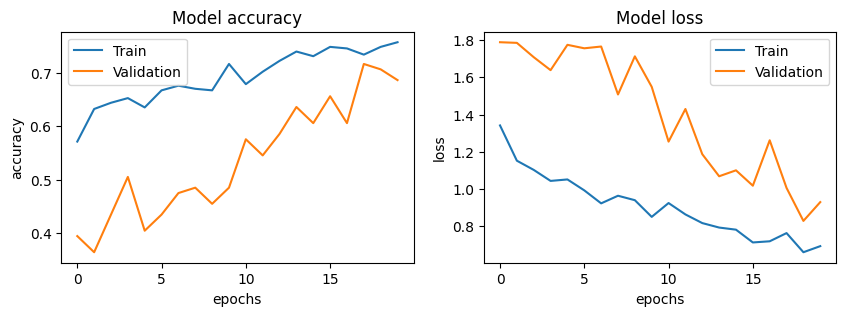

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Validation'])
plt.show()

## Upotreba modela

1/1 [==============================] - 0s 24ms/step


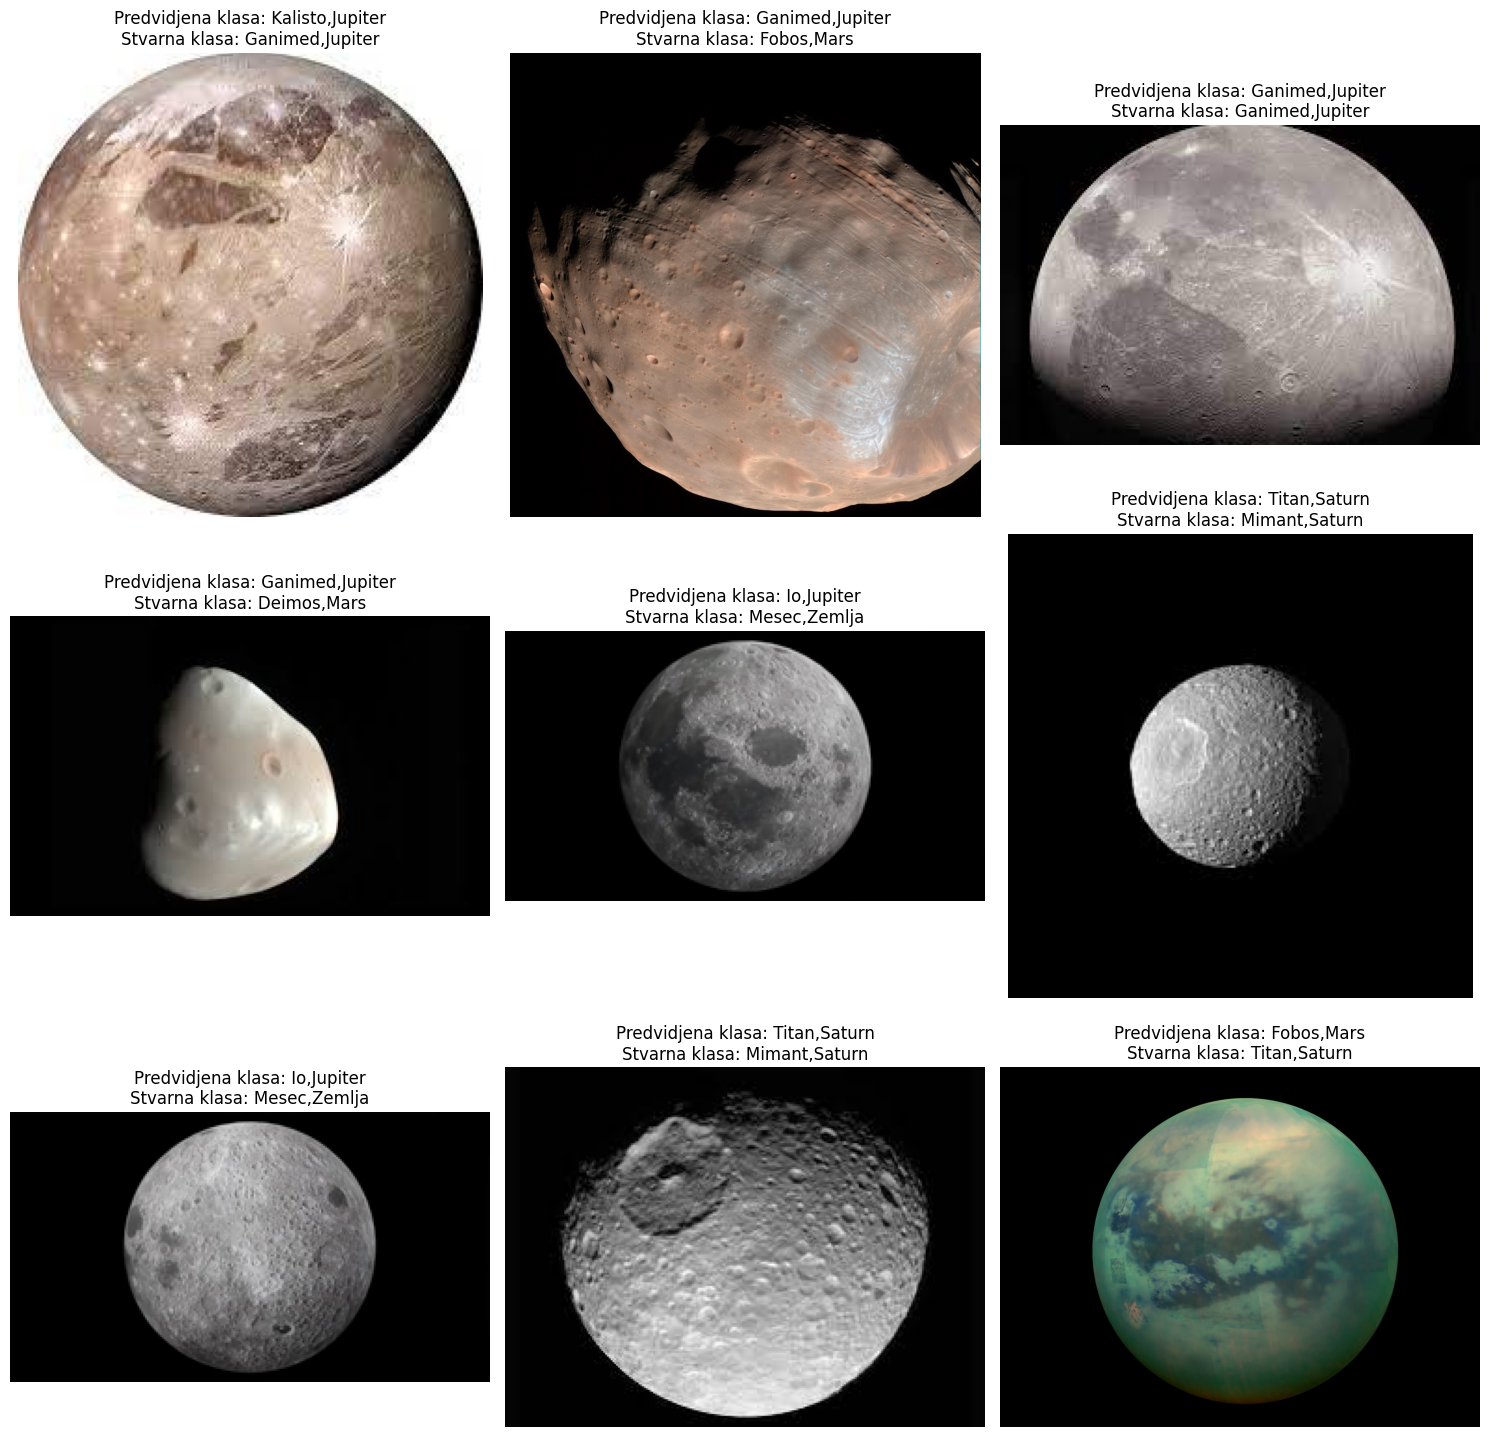

In [23]:
# Dobijanje random 9 putanja iz test generatora
putanje = np.random.choice(test_generator_sateliti.filepaths, 9, replace=False)

# Prikazivanje slika sa random putanja
plt.figure(figsize=(15, 15))
for i, putanja in enumerate(putanje):
    # Učitavanje slike
    slika = plt.imread(putanja)

    # Učitavanje slike sa putanje
    img = image.load_img(putanja, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Normalizacija slike 
    x = x / 255.0  # Normalizacija piksela na [0, 1] opseg
    
    # Predviđanje klase
    predikcija = model.predict(x)
    
    # Pretvaranje predikcije u čitljiv oblik
    klasa_predikcije = sateliti[np.argmax(predikcija)]
    
    # Dobijanje oznake klase iz putanje
    klasa = putanja.split('/')[-2]  # Pretpostavka da je klasa pretposlednji deo putanje
    
    # Prikaz slike
    plt.subplot(3, 3, i + 1)
    plt.imshow(slika)
    plt.title(f'Predvidjena klasa: {klasa_predikcije},{planeta_kojoj_pripada(klasa_predikcije)}\nStvarna klasa: {klasa},{planeta_kojoj_pripada(klasa)}')
    plt.axis('off')

plt.tight_layout()
plt.show()



### Matrica konfuzije

1/1 [==============================] - 0s 33ms/step


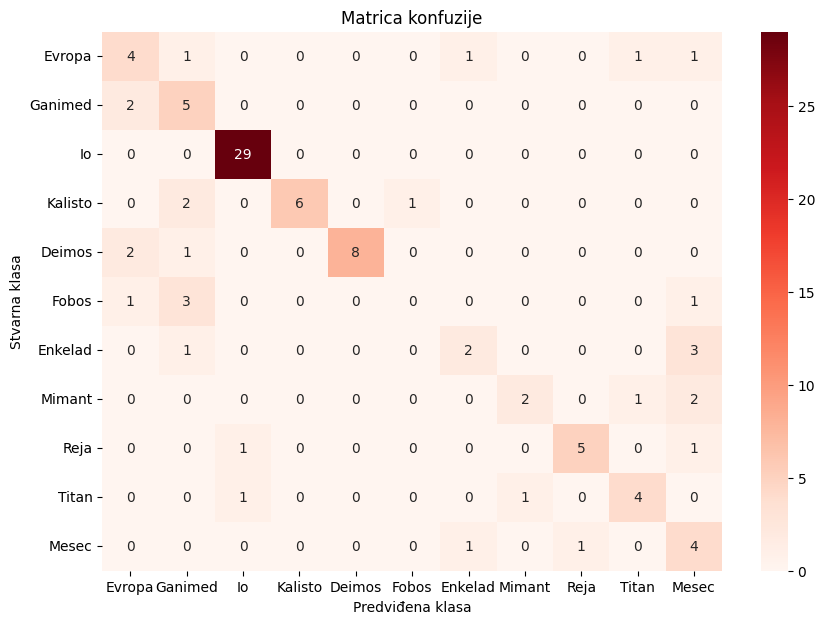

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Priprema podataka za matricu konfuzije
y_true = test_generator_sateliti.labels
y_pred = []

# Predviđanje klasa za sve slike iz test generatora
for i in range(len(test_generator_sateliti)):
    x, _ = test_generator_sateliti[i]
    pred = model.predict(x)
    pred_classes = np.argmax(pred, axis=1)
    y_pred.extend(pred_classes)

# Kreiranje matrice konfuzije
matrica_konfuzije = confusion_matrix(y_true, y_pred)

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=sateliti, columns=sateliti)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()



# Zaključak i komparacija

## Bez augmentovanih slika

Kod planeta je dobijena apsolutna preciznost na test skupu uz minimalni gubitak. Model je pokazao zadovoljavajuće performanse u rešavanju tog problema.  
Međutim, kod satelita, situacija je nešto drugačija. Model je imao problema u prepoznavanju klasa, i za to mogu biti različiti uzroci:  nedovoljna različitost u samim slikama koje predstavljaju klase, nebalansirane klase, ili nedovoljno velika baza podataka.  
Što se tiče nedovoljne različitosti, i ljudskom oku će pojedini sateliti izgledati poprilično slično, tako da na ovaj faktor ne možemo puno da utičemo.   

Prvi pokušaj optimizacije je bio u podešavanju klasnih težina.  
Ova metoda je postigla efekat da model više nije mešao klasu Io i klasu Mesec, i model je imao za nijansu bolje rezultate. Procena tačnosti je porasla sa oko 30% na oko 40%, ali gubitak je ostao isti. 

## Sa augmentovanim slikama

Kod primene modela nad veštački generisanim skupom slika, dobijeni rezultati su, iako veoma visoki sa preciznošću od 98%, zapravo gori nego u pređašnjem slučaju. Uzroci mogu biti različite prirode, od hardverskih komponenti ovog računara (npr. GPU), do broja epoha kojima je model treniran. Pošto su hiperparametri isti u oba slučaja, rezultati su robusni na njih.  

Ono što se može primetiti je značajno poboljšanje u klasifikaciji satelita, gde je u ovom slučaju oko 67%, što je duplo više nego u prvom, neoptimizovanom slučaju, a gubitak je takođe značajno manji (u prvom slučaju iznosi oko 3, a u drugom oko 0.8), što znači da je model imao bolju sposobnost prilagođavanja na neviđenim podacima.
Matrica konfuzije takođe demonstrira sposobnosti istreniranog modela, i na dijagonali se pretežno nalaze najviše vrednosti.